# TP 6 Réseaux de neurones - Multi classification et Propagation en arrière
Dans ce TP, nous aimerions entrainer un réseau de neurones pour la tâche de classification en utilisant l'algorithme d propagation en arrière (backpropagation).

L'ensemble de données que nous allons utiliser est le même que celui utilisé durant le TP1, i.e. les images de chiffres manuscrits.


# Importation des librairies necessaires au travail

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import random

# Lecture des fichiers de données
Pour ce TP, nous allons lire les données à partir d'un fichier csv.

In [2]:
# données
data = np.genfromtxt('data.csv', delimiter=',', dtype=float)
data.shape

(5000, 401)

Dans ces données (data), les 400 premières colonnes representent les pixels de l'image (20x20), la dernière colonne represente la classe de l'image (chiffres de 0 à 9). (http://yann.lecun.com/exdb/mnist/)

Chaque ligne represente un exemple de notre ensemble de données. 

Mettons ces données dans leurs vecteurs correspondants.

In [3]:
# rajoutons l'ordonnée à l'origine theta 0
intercept = np.ones((data.shape[0],1))
X = np.column_stack((intercept,data[:,:-1]))
y = data[:,-1]
# forcer y à avoir une seule colonne
y = y.reshape(-1, 1)

In [4]:
print('X', X.shape ,' y ', y.shape)

X (5000, 401)  y  (5000, 1)


Visualisation aléatoire de quelques données

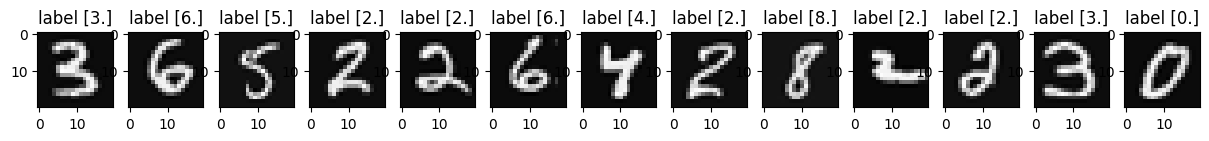

In [5]:
plt.figure(figsize=(15,8))
for l in range(1, 14):
    c = random.randint(X.shape[0])
    a_l = X[c,1:].reshape((20, 20)).T
    plt.subplot(1,13, l)
    plt.title(f'label {y[c]}')
    plt.imshow(a_l, cmap='gray')

Transformer y de tel sorte à avoir un vecteur pour chaque exemple

Equivalent de tocategorical

In [6]:
YY = np.zeros((y.shape[0], int(np.max(y))+1))
YY.shape

(5000, 10)

In [7]:
YY[np.arange(YY.shape[0]),y.astype(int).reshape(-1,)] = 1

# Réseaux de neurones
Pour cette partie, nous choisissons une réseau simple:

- une couche d'entrée avec 400 noeuds (20 x 20 pixels) + le biais
- une couche cachée avec 25 noeuds
- une couche de sortie avec 10 noeuds (nombre de classes)

In [8]:
# poids de la couche 1
W1 = np.genfromtxt('W1.csv', delimiter=',', dtype=float)
W1.shape


(25, 401)

In [9]:
# poids de la couche 2
W2 = np.genfromtxt('W2.csv', delimiter=',', dtype=float)
W2.shape

(10, 26)

In [10]:
input_layer_size  = 400
hidden_layer_size = 25   
num_labels = 10

# Calcul du coût

In [11]:
def Sigmoid(z):
    # pour une valeur donnée, cette fonction calculera sa sigmoid
    return 1 / (1+np.exp(np.clip(-z, -500, 500)))

In [12]:
def compute_activations(X: np.ndarray, *thetas: np.ndarray) -> list[np.ndarray]:
    """ Compute activations for each layer 
    
    Args:
        X: array of features (m, n)
        *thetas: list of theta matrices for each layer.
    Returns:
        activations: list of activations for each layer without bias
    """

    activations = []
    a = X
    for theta in thetas:
        a = Sigmoid(np.matmul(a, np.transpose(theta)))
        activations.append(a)
        a = np.column_stack((np.ones((a.shape[0],1)), a))
    return activations

# TODO  1 calcul du coût
**Tâche 1**: Modifier la fonction computeCost afin d'obtenir un coût avec régularisation

Rappelons que le coût avec régularisation est calculé comme suit:

$ J(\theta)= \frac{1}{m} \sum_{i=1}^m\sum_{k=1}^K \left[ -y_k^{(i)} \log (h_\theta(x^{(i)}) )_k - (1-y_k^{(i)}) \log (1-h_\theta(x^{(i)}) )_k \right] + \frac{\lambda}{2m} \left[ \sum_{j=1}^{25}\sum_{k=1}^{400} \left( \theta_{j,k}^{(1)} \right)^2 +   \sum_{j=1}^{10}\sum_{k=1}^{25} \left( \theta_{j,k}^{(2)} \right)^2 \right] $

In [13]:
def computeCost(X: np.ndarray, YY: np.ndarray, *thetas:np.ndarray, lambda_=0):
    m = X.shape[0]
    a1 = X
    theta1, theta2 = thetas

    intercept = np.ones((m,1))
    z2 = np.column_stack((intercept, np.matmul(a1, np.transpose(theta1))))
    a2 = Sigmoid(z2)
    a2[:,0] = 1

    z3 = np.matmul(a2, np.transpose(theta2))
    a3 = Sigmoid(z3)

    reg = (lambda_/(2*m)) * np.sum([np.sum(theta[:,1:]**2) for theta in thetas])
    J = (-np.sum((YY*np.log(a3)) + (1-YY) * np.log(1-a3))) / m + reg

    return J

# TODO  2 calcul du gradient
**Tâche 2**: Implémenter la fonction NNCostFunction afin de retourner:

- Le coût avec régularisation
- Le gardient du coût par rapport à chaqu'un des paramètres du réseau

Rappelons le gradient de la sigmoid:

$ sigmoid(z) =\sigma(z)= \frac{1}{1-e^{-z}}$

$ \sigma(z)^\prime = \sigma(z)(1-\sigma(z)) =a(1-a)$ tel que $a$ est l'activation d'une couche donnée

L'algorithme à implementer est comme suit:

Pour chaque exemple de l'ensemble d'apprentissage faire

Pour chaque noeud de la couche de sortie, calculer la dérivée (gradient):

$\delta_k^{(3)} = \left( a_k^{(3)}- y_k \right)  $

Pour chaque noeud de la couche caché calculer la dérivée (gradient):

$\delta^{(2)} =  \left(\Theta^{(2)}\right)^T \delta^{(3)} \quad .* \quad \sigma^\prime\left(z^{(2)} \right) $

Notons que l'opérateur $.*$ represente la multiplication élement par élement et non pas la multiplication matricielle

Le gradient de chaque noeud et de chaque couche sera finalement:

$\Delta^{(l)} =  \Delta^{(l)} + \delta^{(l)} * \left( a^{(l)} \right)^T $

Fin pour

Fin pour

Diviser le gradient cumulé par le nombre d'exemples:

$ \frac{\partial J(\Theta)} { \partial \Theta_{i,j)}^{(l)}} = \frac{1}{m} \Delta_{i,j)}^{(l)}$


In [14]:
def NNCostFunction(X: np.ndarray, YY: np.ndarray, *thetas: list[np.ndarray], lambda_=0):
    m = X.shape[0]
    activations = compute_activations(X, *thetas)
    Deltas = [np.zeros_like(theta) for theta in thetas]
    
    for i in range(m):
        A = [a[i].reshape(-1,1) for a in activations]
        a_l = A.pop(-1)
        prev_delta = a_l - YY[i].reshape(-1,1)
        for Delta, theta, a in zip(Deltas[::-1], thetas[::-1], A[::-1]):
            # add bias
            a = np.vstack((np.ones((1, a.shape[1])), a))
            Delta += np.matmul(prev_delta, np.transpose(a))
            prev_delta = np.matmul(np.transpose(theta), prev_delta) * a * (1-a)

    regularizations = [np.hstack((np.zeros((theta.shape[0],1)), theta[:,1:])) for theta in thetas]
    grad = [Delta/m + (lambda_/m)*reg for Delta, reg in zip(Deltas, regularizations)]
    J = computeCost(X, YY, *thetas, lambda_=lambda_)

    return J, grad

# TODO  3 entrainement du réseau
**Tâche 3**: Entrainer le réseau en utilisant la descente du gradient:
Ici il faudra reprendre l'algorithme de la descente du gradient afin de mettre à jour les paramètres du réseau


In [15]:
def gradientDescent(X: np.ndarray, y: np.ndarray, Theta: list[np.ndarray], alpha: float, iterations: int, lambda_=0):
    J_history = np.zeros((iterations, 1))
    for i in range(iterations):
        J, grad = NNCostFunction(X, y, *Theta, lambda_=lambda_)
        J_history[i] = J
        if i % 10 == 0:
            print(f'Iteration {i} - Cost {J}')
        Theta = [theta - alpha * g for theta, g in zip(Theta, grad)]
    return Theta, J_history

In [16]:
# initialisation des poids
np.random.seed(12345)
initial_Theta1 = np.random.rand(hidden_layer_size, input_layer_size+1)
initial_Theta2 = np.random.rand(num_labels, hidden_layer_size+1)
Theta1 = [initial_Theta1, initial_Theta2]

In [17]:
# entrainement
Theta1, J_history = gradientDescent(X, YY, Theta1, 0.5, 101)

Iteration 0 - Cost 120.85802418087935


Iteration 10 - Cost 3.2508272599446943
Iteration 20 - Cost 3.250827224154837
Iteration 30 - Cost 3.2508272239543805
Iteration 40 - Cost 3.2508272237539244
Iteration 50 - Cost 3.2508272235534688
Iteration 60 - Cost 3.2508272233530127
Iteration 70 - Cost 3.250827223152556
Iteration 80 - Cost 3.2508272229521
Iteration 90 - Cost 3.250827222751644
Iteration 100 - Cost 3.250827222551188


# TODO 4 : Régularisation
Mettre à jour le calcul du coût en ajoutant le terme de régularisation et comparer les résultats (avec et sans régularisation)

In [18]:
# initialisation des poids
np.random.seed(12345)
initial_Theta1 = np.random.rand(hidden_layer_size, input_layer_size+1)
initial_Theta2 = np.random.rand(num_labels, hidden_layer_size+1)
Theta2 = [initial_Theta1, initial_Theta2]

In [19]:
Theta2, J_history = gradientDescent(X, YY, Theta2, 0.4, 51, lambda_=0.1)

Iteration 0 - Cost 120.89258793698185
Iteration 10 - Cost 3.284725314149747
Iteration 20 - Cost 3.284719892362567
Iteration 30 - Cost 3.284714471559271
Iteration 40 - Cost 3.284709051622371
Iteration 50 - Cost 3.2847036325517287


# TODO 5 : Prédiction

Appliquer une propagation en avant en utilisant les paramètres données pour prédir les classes de l'ensemble d'apprentissage.



In [20]:
def predict (X, W1, W2):
    activations = compute_activations(X, W1, W2)
    output = activations[-1]
    y_pred = np.argmax(output, axis=1).reshape(-1, 1)
    return y_pred

In [21]:
# calcul de precision = nombre de valeurs bien prédites (ici sur toute la base X)
y_pred=predict(X, W1, W2)
precision_given = np.mean(y==y_pred)*100
precision_given

0.12

In [22]:
y_pred=predict(X, *Theta1)
precision = np.mean(y==y_pred)*100
precision

10.280000000000001

In [23]:
y_pred=predict(X, *Theta2)
precision_reg = np.mean(y==y_pred)*100
precision_reg

10.22

# optionnel 1 : Vérification de l'implementation
Comparer vos algorithmes à ceux de scikitlearn

In [24]:
from sklearn.neural_network import MLPClassifier

In [25]:
nn = MLPClassifier(hidden_layer_sizes=(25,), activation='logistic', solver='sgd', max_iter=500, batch_size=y.shape[0], learning_rate_init=0.4, alpha=0.4)

In [26]:
nn.fit(X, YY)

C:\Users\taouc\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(activation='logistic', alpha=0.4, batch_size=5000,
              hidden_layer_sizes=(25,), learning_rate_init=0.4, max_iter=500,
              solver='sgd')

In [27]:
y_pred = nn.predict(X)
y_pred = np.argmax(y_pred, axis=1).reshape(-1)
precision_sk = np.mean(y_pred == y.astype(int).reshape(-1)) * 100
precision_sk

92.10000000000001

# Optionnel 2 : Visualisation des poids
    
La visualisation de poids permet de voir quel partie du réseau est activé et pour quelle classe.
Il est possible de visulaiser les paramètres theta1 . 
Ceci peut se faire en utilisant un reshape de ces paramètres afin d'avoir 25 images de taille 20x20 (n'oubliez pas d'ignorer la premuère colonne, celle du biais)

# Optionnel 3 : Renforcement de l'apprentissage
Mettre ici toute idée qui pourrait renforcer votre apprentissage

- use classes to cache values
- divide the training set into mini-batches
- vectorize the implementation